In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('all_seasons_working.csv')

DATA CLEANING AND DEALING WITH OUTLIERS

In [3]:
# changing 'draft number' column from object type to int type 
df.draft_number = pd.to_numeric(df.draft_number, errors='coerce').fillna(0).astype(np.int64)
# # group by name
mean_val_players = df.groupby('player_name').mean()
# dropping players with draft number not in range(1, 61) (we want to base on new form of draft where max draft number is 60)

drafted_players_grouped = mean_val_players[(mean_val_players['draft_number'] > 0) & (mean_val_players['draft_number'] < 61)]
# choosing only players that have played decent amount of games during their careers (avg half a season 
# games played every year) and also choosing players that avg more than 5pts per game in a season 
# - this is due to lack of a column 'minutes played'. I want to avoid a situation where a player with 
# a lot of games played, was only 0-10 min on a court every game and his stats are lowered due to that. 
drafted_players_grouped = drafted_players_grouped[(drafted_players_grouped['gp'] > 41) & (drafted_players_grouped['pts'] > 4)]
drafted_players_grouped

,Unnamed: 0,age,player_height,player_weight,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
player_name,,,,,,,,,,,,,,,
A.C. Green,1114.400000,35.000000,205.740000,102.058200,23.0,75.800000,5.780000,6.060000,0.860000,-1.880000,0.093000,0.186400,0.127400,0.486800,0.054000
AJ Price,7113.833333,25.500000,187.960000,84.821704,52.0,43.500000,5.350000,1.333333,2.000000,-2.233333,0.017667,0.090833,0.210667,0.476500,0.248833
Aaron Brooks,7535.500000,28.100000,182.880000,73.028312,26.0,64.500000,8.880000,1.550000,2.760000,-3.310000,0.022700,0.069700,0.222200,0.521000,0.230700
Aaron Gordon,9931.857143,22.000000,205.014286,101.734206,4.0,64.714286,12.500000,6.271429,2.442857,-1.328571,0.057571,0.172714,0.198143,0.531286,0.124429
Aaron Holiday,10823.333333,23.000000,183.726667,83.914520,23.0,60.666667,7.533333,1.666667,2.333333,3.000000,0.011000,0.075000,0.192333,0.514000,0.169000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zarko Cabarkapa,3730.000000,24.000000,210.820000,104.326160,17.0,50.000000,4.466667,2.133333,0.566667,-6.333333,0.071000,0.167667,0.218000,0.504000,0.094000
Zaza Pachulia,6762.375000,27.500000,210.820000,123.036830,42.0,68.625000,6.700000,5.743750,1.318750,0.350000,0.121500,0.206875,0.166312,0.540312,0.097812
Zeljko Rebraca,3239.200000,32.000000,213.360000,118.024638,54.0,43.000000,5.560000,2.960000,0.360000,-2.760000,0.074400,0.168600,0.184000,0.577200,0.044000


In [4]:
# I want to check correlation of draft_number with the rest of the features
drafted_players_grouped.corr()['draft_number'].sort_values()

pts             -0.370210
reb             -0.299325
usg_pct         -0.287503
ast             -0.186572
dreb_pct        -0.160155
player_height   -0.150038
gp              -0.139522
player_weight   -0.119477
net_rating      -0.075380
oreb_pct        -0.070711
ast_pct         -0.062249
ts_pct          -0.049719
age             -0.002965
Unnamed: 0       0.032050
draft_number     1.000000
Name: draft_number, dtype: float64

In [5]:
X = drafted_players_grouped.drop(columns=['draft_number', 'age', 'gp', 'Unnamed: 0', 'player_height',
                                          'player_weight'], axis=1)

y = drafted_players_grouped['draft_number']

In [6]:
from sklearn.preprocessing import PolynomialFeatures
# degree - it will create x^2 plot and include_bias - it will create columns of 1
# (the degree was changed to 1 due to smaller RMSE error - it will be shown below)
polynomial_converter = PolynomialFeatures(degree=1, include_bias=False)
poly_features = polynomial_converter.fit_transform(X)
print(poly_features)

[[ 5.78        6.06        0.86       ...  0.1274      0.4868
   0.054     ]
 [ 5.35        1.33333333  2.         ...  0.21066667  0.4765
   0.24883333]
 [ 8.88        1.55        2.76       ...  0.2222      0.521
   0.2307    ]
 ...
 [ 5.56        2.96        0.36       ...  0.184       0.5772
   0.044     ]
 [24.75        6.75        2.9        ...  0.289       0.6325
   0.1535    ]
 [12.93846154  7.33846154  1.09230769 ...  0.22992308  0.53130769
   0.06938462]]


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

CREATING SCALED FEATURES

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# create inscance of scaler
stan_scaler = StandardScaler()
norm_scaler = MinMaxScaler()

# fitting scaler to X_train
stan_scaler.fit(X_train)
norm_scaler.fit(X_train)

# creating our data:
# standarized features
stan_X_train = stan_scaler.transform(X_train)
stan_X_test = stan_scaler.transform(X_test)

# normalized features
norm_X_train = norm_scaler.transform(X_train)
norm_X_test = norm_scaler.transform(X_test)

# standarized and normalized features
norm_stan_X_train = stan_scaler.transform(norm_X_train)
norm_stan_X_test =stan_scaler.transform(norm_X_test)

RIDGE REGRESSION IMPLEMENTATION 

In [9]:
# RidgeCV will perform cross-validation for variety of alpha hyperparameters
from sklearn.linear_model import RidgeCV
stan_ridge_cv_model = RidgeCV(alphas=(150, 200, 250, 280, 290, 300, 310, 320, 330, 350, 400, 450), 
                              cv=20, scoring='neg_root_mean_squared_error')
norm_ridge_cv_model = RidgeCV(alphas=(0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0), 
                              cv=20, scoring='neg_root_mean_squared_error')
norm_stan_ridge_cv_model = RidgeCV(alphas=(0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0), 
                                   cv=20, scoring='neg_root_mean_squared_error')

# use it only on training set! Small portion of this set will be validation set for aplha parameters
stan_ridge_cv_model.fit(stan_X_train, y_train)
norm_ridge_cv_model.fit(norm_X_train, y_train)
norm_stan_ridge_cv_model.fit(norm_stan_X_train, y_train)

# here is displayed the best alpha parameter from the ones we choosed in 'alphas'
print(stan_ridge_cv_model.alpha_, '\n', norm_ridge_cv_model.alpha_, '\n', norm_stan_ridge_cv_model.alpha_)

stan_test_predictions = stan_ridge_cv_model.predict(stan_X_test)
norm_test_predictions = norm_ridge_cv_model.predict(norm_X_test)
norm_stan_test_predictions = norm_stan_ridge_cv_model.predict(norm_stan_X_test)

stan_MAE = mean_absolute_error(y_test, stan_test_predictions)
norm_MAE = mean_absolute_error(y_test, norm_test_predictions)
norm_stan_MAE = mean_absolute_error(y_test, norm_stan_test_predictions)
print(stan_MAE, '\n', norm_MAE, '\n', norm_stan_MAE)

stan_RMSE = np.sqrt(mean_squared_error(y_test, stan_test_predictions))
norm_RMSE = np.sqrt(mean_squared_error(y_test, norm_test_predictions))
norm_stan_RMSE = np.sqrt(mean_squared_error(y_test, norm_stan_test_predictions))
print(stan_RMSE, '\n', norm_RMSE, '\n', norm_stan_RMSE)

150 
 0.5 
 0.1
10.822063870951407 
 10.699983879290082 
 10.752759596768179
13.48331860063137 
 13.474237575432939 
 13.52678547781084


In [10]:
# displays different errors that could be used as a scoring metrics. Every single one of them is 
# transformed: higher value -> better (thats why we got neg_ somewhere)
# these errors are for any kind of models - not only for linear regression
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [11]:
print(stan_ridge_cv_model.coef_, '\n', norm_ridge_cv_model.coef_, '\n', norm_stan_ridge_cv_model.coef_)


[-2.66907814 -1.87624502 -1.35765184  0.66442023  0.15043018 -0.94535151
 -1.42301765  1.24335518  1.10012017] 
 [-16.58018362  -9.6254276  -22.69995595   6.7100747    2.19397756
  -6.41995966  -8.35903805  15.36425537  18.92039994] 
 [-31.37774998 -28.23694911 -52.87926265  24.35951368   0.14366137
  -0.23299092  -0.59012929   0.61912667   2.28036994]


LASSO REGRESSION IMPLEMENTATION (Least absolute shrinkage and selection operator)

In [12]:
from sklearn.linear_model import LassoCV

# the smaller 'eps' is, the wider range is checked
stan_lasso_cv_model = LassoCV(eps=0.001, n_alphas=100, cv=20, max_iter=1000000)
norm_lasso_cv_model = LassoCV(eps=0.001, n_alphas=100, cv=20, max_iter=10000000)
norm_stan_lasso_cv_model = LassoCV(eps=0.001, n_alphas=100, cv=20, max_iter=1000000)

stan_lasso_cv_model.fit(stan_X_train, y_train)
norm_lasso_cv_model.fit(norm_X_train, y_train)
norm_stan_lasso_cv_model.fit(norm_stan_X_train, y_train)
print(stan_lasso_cv_model.alpha_, '\n', norm_lasso_cv_model.alpha_, '\n', norm_stan_lasso_cv_model.alpha_)

stan_test_predictions = stan_lasso_cv_model.predict(stan_X_test)
norm_test_predictions = norm_lasso_cv_model.predict(norm_X_test)
norm_stan_test_predictions = norm_stan_lasso_cv_model.predict(norm_stan_X_test)

stan_MAE = mean_absolute_error(y_test, stan_test_predictions)
norm_MAE = mean_absolute_error(y_test, norm_test_predictions)
norm_stan_MAE = mean_absolute_error(y_test, norm_stan_test_predictions)
print(stan_MAE, '\n', norm_MAE, '\n', norm_stan_MAE)

stan_RMSE = np.sqrt(mean_squared_error(y_test, stan_test_predictions))
norm_RMSE = np.sqrt(mean_squared_error(y_test, norm_test_predictions))
norm_stan_RMSE = np.sqrt(mean_squared_error(y_test, norm_stan_test_predictions))
print(stan_RMSE, '\n',norm_RMSE, '\n',norm_stan_RMSE)

0.08312753565140421 
 0.0009705487889655561 
 0.017384559096365677
10.677922520982213 
 10.715806693174294 
 10.825817720705249
13.453547343276643 
 13.515588267723679 
 13.554775281614734


In [13]:
print(stan_lasso_cv_model.coef_, '\n', norm_lasso_cv_model.coef_, '\n', norm_stan_lasso_cv_model.coef_)

[-3.53707232 -1.2637453  -3.78028194  0.97437334  0.         -1.23877787
 -1.06636147  1.83443776  3.58768025] 
 [-11.70136361 -10.68410158 -35.36740029   7.17261084   2.98092426
  -5.87846062 -11.86358826  15.95996643  29.10397711] 
 [ -0.         -31.67663341 -53.74211121   5.69251142   0.18691702
  -0.22442207  -0.82072799   0.57256445   2.32241761]


L1 AND L2 - ELASTIC NET IMPLEMENTATION

In [14]:
from sklearn.linear_model import ElasticNetCV

In [15]:
# 0.1 is 10% lasso, 90% ridge
# n_alphas is a lambda outside the bracket
stan_elastic_net_cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], 
                                                  eps=0.001, n_alphas=100, max_iter=1000000)
norm_elastic_net_cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], 
                                                  eps=0.001, n_alphas=100, max_iter=1000000)
norm_stan_elastic_net_cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], 
                                                  eps=0.001, n_alphas=100, max_iter=1000000)

stan_elastic_net_cv_model.fit(stan_X_train, y_train)
norm_elastic_net_cv_model.fit(norm_X_train, y_train)
norm_stan_elastic_net_cv_model.fit(norm_stan_X_train, y_train)

print(stan_elastic_net_cv_model.l1_ratio_, '\n',norm_elastic_net_cv_model.l1_ratio_, '\n', norm_stan_elastic_net_cv_model.l1_ratio_)

stan_test_predictions = stan_elastic_net_cv_model.predict(stan_X_test)
norm_test_predictions = norm_elastic_net_cv_model.predict(norm_X_test)
norm_stan_test_predictions = norm_stan_elastic_net_cv_model.predict(norm_stan_X_test)

stan_MAE = mean_absolute_error(y_test, stan_test_predictions)
norm_MAE = mean_absolute_error(y_test, norm_test_predictions)
norm_stan_MAE = mean_absolute_error(y_test, norm_stan_test_predictions)                                                                                                             
print(stan_MAE, '\n', norm_MAE, '\n', norm_stan_MAE)
                                                      
stan_RMSE = np.sqrt(mean_squared_error(y_test, stan_test_predictions))
norm_RMSE = np.sqrt(mean_squared_error(y_test, norm_test_predictions))                                                          
norm_stan_RMSE = np.sqrt(mean_squared_error(y_test, norm_stan_test_predictions))                                                                                                                                                                                                                       
print(stan_RMSE, '\n', norm_RMSE, '\n', norm_stan_RMSE)

0.7 
 0.9 
 1.0
10.701186754466159 
 10.694234140200699 
 10.825817720705249
13.458565885889982 
 13.458966665874886 
 13.554775281614734


PLOTTING THE RESULTS FOR DIFFERENT FUNCTION DEGREE

In [16]:
# Creating a loop for polynomial regression to check how our reggresion model behaves on 
# different function degree
# I choosed to plot only elastic-net regression model with standarized and normalized data 
from sklearn.preprocessing import PolynomialFeatures

elasticnet_norm_stan_train_RMSE_error = []
elasticnet_norm_stan_test_RMSE_error = []

for d in range(1,5):
    polynomial_converter = PolynomialFeatures(degree=d, include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
    
    # create inscance of scaler
    stan_scaler = StandardScaler()
    norm_scaler = MinMaxScaler()
    # fitting scaler to X_train
    stan_scaler.fit(X_train)
    norm_scaler.fit(X_train)
    # creating our data:
    # standarized features
    stan_X_train = stan_scaler.transform(X_train)
    stan_X_test = stan_scaler.transform(X_test)
    # normalized features
    norm_X_train = norm_scaler.transform(X_train)
    norm_X_test = norm_scaler.transform(X_test)
    # standarized and normalized features
    norm_stan_X_train = stan_scaler.transform(norm_X_train)
    norm_stan_X_test =stan_scaler.transform(norm_X_test)
    
    # ELASTIC NET REGRESSION PATH TO FIND RMSE
    norm_stan_elastic_net_cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], 
                                                      eps=0.001, n_alphas=100, max_iter=1000000)


    norm_stan_elastic_net_cv_model.fit(norm_stan_X_train, y_train)

    norm_stan_train_predictions = norm_stan_elastic_net_cv_model.predict(norm_stan_X_train)
    norm_stan_test_predictions = norm_stan_elastic_net_cv_model.predict(norm_stan_X_test)

    elastic_norm_stan_train_RMSE = np.sqrt(mean_squared_error(y_train, norm_stan_train_predictions)) 
    elastic_norm_stan_test_RMSE = np.sqrt(mean_squared_error(y_test, norm_stan_test_predictions))

    elasticnet_norm_stan_train_RMSE_error.append(elastic_norm_stan_train_RMSE)
    elasticnet_norm_stan_test_RMSE_error.append(elastic_norm_stan_test_RMSE)

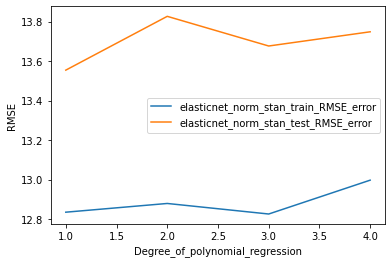

In [17]:
plt.plot(range(1, 5), elasticnet_norm_stan_train_RMSE_error[:4], label='elasticnet_norm_stan_train_RMSE_error')
plt.plot(range(1, 5), elasticnet_norm_stan_test_RMSE_error[:4], label='elasticnet_norm_stan_test_RMSE_error')

plt.xlabel('Degree_of_polynomial_regression')
plt.ylabel('RMSE')
plt.legend()
# plot below looks better in comparison with nba_project.ipynb file. We can see that we do not have huge
# leap in RMSE value in test_set. Nonetheless, the RMSE is still pretty big, taking into consideration
# fact, that we have only 60 draft numbers.

DEPLOYMENT OF A MODEL

In [18]:
from joblib import dump, load
final_model = norm_stan_elastic_net_cv_model
# we want to retrain on all the data before final deployment
final_model.fit(X,y)
# saves the model
dump(norm_stan_elastic_net_cv_model, 'reg_final_draft_prediction.joblib')

['reg_final_draft_prediction.joblib']

In [19]:
# loading ready model 
loaded_model = load('reg_final_draft_prediction.joblib')

# model coeficients:
loaded_model.coef_

array([-0.96429605, -1.31113036, -0.66636479,  0.21496016, -0.        ,
       -0.        , -0.        , 22.23675136,  8.10161156])

In [20]:
# lets try to predict draft number for a player with stats like these:
# something around Lebron James career stats:
some_guy = [[27, 9, 7, 2.5, 0.08, 0.05, 0.3, 0.55, 0.3]]

In [21]:
loaded_model.predict(some_guy)

array([-3.69757394])

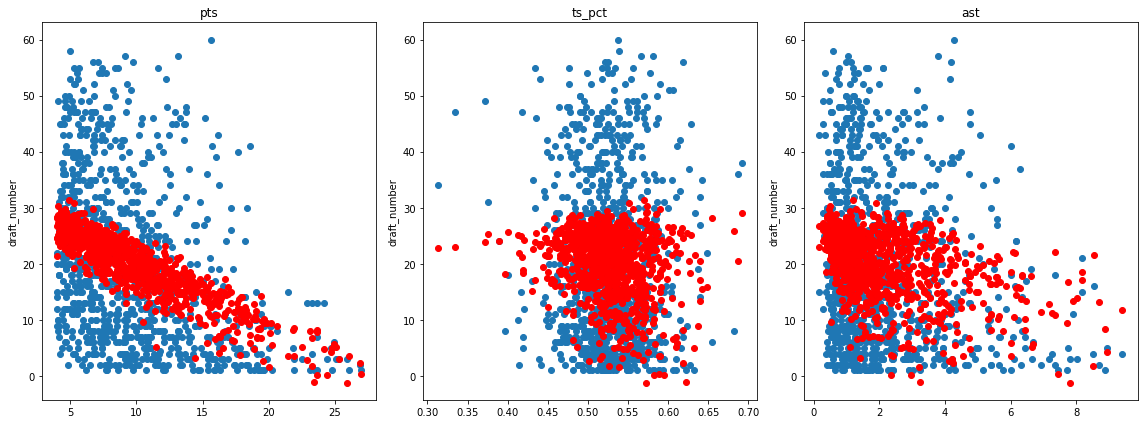

In [22]:
# showing on plot true values and values predicted by a model
y_hat = loaded_model.predict(X)

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,6))

axes[0].plot(drafted_players_grouped['pts'],drafted_players_grouped['draft_number'],'o')
axes[0].plot(drafted_players_grouped['pts'],y_hat,'o',color='red')
axes[0].set_ylabel('draft_number')
axes[0].set_title("pts")

axes[1].plot(drafted_players_grouped['ts_pct'],drafted_players_grouped['draft_number'],'o')
axes[1].plot(drafted_players_grouped['ts_pct'],y_hat,'o',color='red')
axes[1].set_title("ts_pct")
axes[1].set_ylabel('draft_number')

axes[2].plot(drafted_players_grouped['ast'],drafted_players_grouped['draft_number'],'o')
axes[2].plot(drafted_players_grouped['ast'],y_hat,'o',color='red')
axes[2].set_title("ast");
axes[2].set_ylabel('draft_number')
plt.tight_layout();

# red color are values predicted by a model
# we can see that the model is not precise. We should try different approach to get the answer for 
# our main question and compare results.